# [DM 2025/26] Phoneme Classification

In [72]:
# Library importing

## ML
import sklearn.datasets as skl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

import numpy as np
import pandas as pd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

## Utilities
import csv
import os


from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Utilities

In [ ]:
def save_csv_dataset(data: pd.DataFrame, save_name: str):
    
    if not save_name.endswith('.csv'):
        save_name += '.csv'
    
    data.to_csv(save_name, index=False, encoding='utf-8')
    abs_path = os.path.abspath(save_name)
    
    print(f"Dataset salvato in: {abs_path}")
    print(f"Righe: {len(data)}, Colonne: {len(data.columns)}")
    
    return abs_path

## 1. Dataset Analysis

In [74]:
# Dataset import
dataset = fetch_openml(name="phoneme", version=1)

# Isolating features and labels
data = dataset.data
labels = dataset.target

# Taking feature names and label names
feature_names = dataset.feature_names
label_counts = np.unique_counts(labels)

In [75]:
data.head()

,V1,V2,V3,V4,V5
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418
1,-0.641265,0.109245,0.292130,-0.916804,0.240223
2,0.870593,-0.459862,0.578159,0.806634,0.835248
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127


In [76]:
labels.value_counts()

Class
1    3818
2    1586
Name: count, dtype: int64

In [77]:
# Extracting statistics on data
data.describe()

,V1,V2,V3,V4,V5
count,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03
mean,3.330866e-09,5.551443e-09,6.106588e-09,-9.437454e-09,-6.698742e-08
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.933743e+00,-3.038709e+00,-2.795869e+00,-2.485340e+00,-2.367461e+00
25%,-6.697555e-01,-7.790800e-01,-9.505788e-01,-7.583255e-01,-5.405418e-01
50%,-3.801605e-01,-2.150985e-01,-3.861800e-02,-1.422555e-01,-2.127475e-01
75%,3.149040e-01,7.136990e-01,7.771393e-01,6.759035e-01,2.045420e-01
max,3.828575e+00,3.664763e+00,2.630868e+00,3.046948e+00,4.586666e+00


From the statistical report we notice that all the features have mean equal to zero and standard deviation equal to 1, so they are already standard scaled.

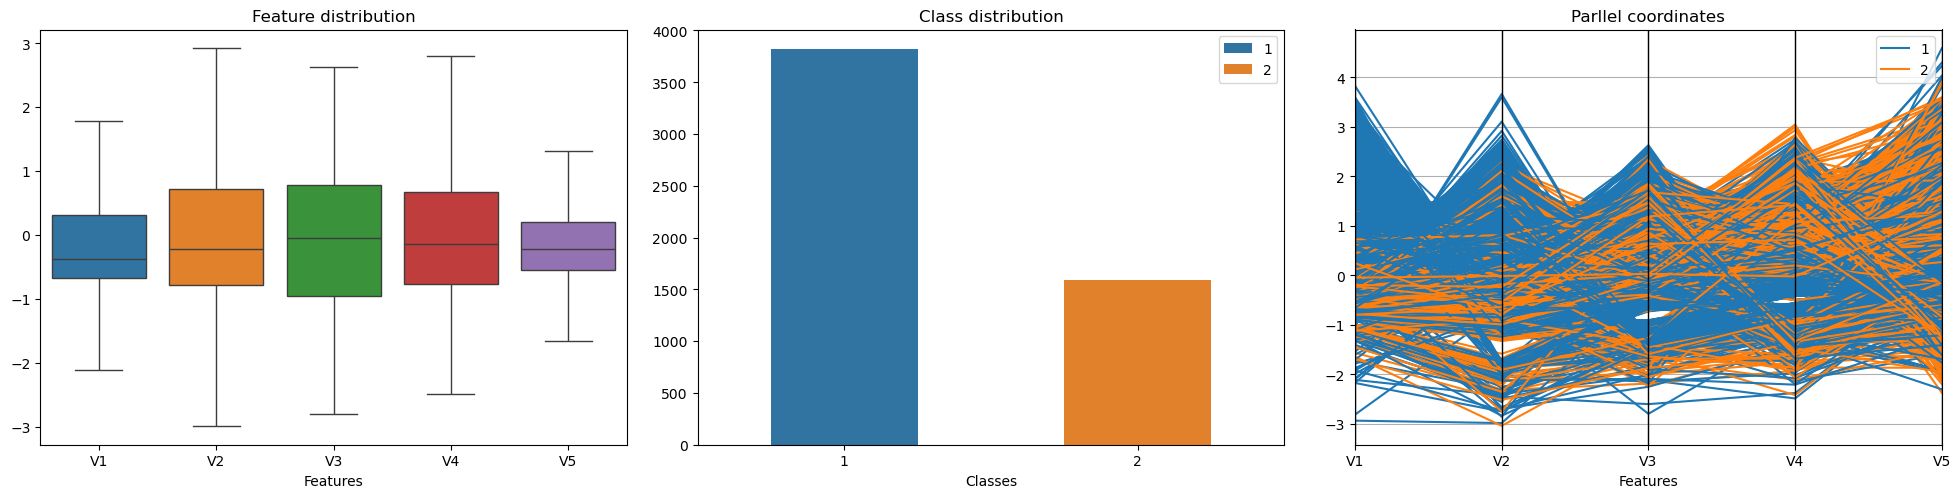

In [78]:
# Creating 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=2)

# Boxplot -> feature distribution 
sns.boxplot(data, 
            palette="tab10", 
            showfliers=False, 
            ax=axs[0]
            )

# Barplot -> class distribution
sns.barplot(x=label_counts.values, 
            y=label_counts.counts, 
            palette="tab10", 
            hue=label_counts.values, 
            legend=True,
            width=0.5, 
            ax=axs[1]
			)

# Building a temporary dataframe with information about classes (necessary for parallel coordinates)
df = data.copy()
df["class"] = labels

# Parallel coordinates
parallel_coordinates(
    frame=df,
    class_column="class",
    color=sns.color_palette("tab10"),
    ax=axs[2]
)

# del df # Deleting the temporary dataset from memory

axs[0].set_title("Feature distribution")
axs[0].set_xlabel("Features")

axs[1].set_title("Class distribution")
axs[1].set_xlabel("Classes")

axs[2].set_title("Parllel coordinates")
axs[2].set_xlabel("Features")

plt.show()

The class distribution shows that the two classes are highly imbalanced with class 1 being represented for more than twice class 2, this suggests need for future preprocessing aimed to balance the class frequency.

## 2. Preprocessing

In [79]:
# Preprocessing variables
RANDOM_SEED = 42
TRAIN_SIZE = 0.75

### 2.1 Missing values handling

In [80]:
data.isna().describe()

,V1,V2,V3,V4,V5
count,5404,5404,5404,5404,5404
unique,1,1,1,1,1
top,False,False,False,False,False
freq,5404,5404,5404,5404,5404


### 2.2 Train-Test split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4053, 5), (1351, 5), (4053,), (1351,))

In [82]:
X_train.to_csv("data/X_train.csv", sep=",", index=False)
X_test.to_csv("data/X_test.csv", sep=",", index=False)
y_train.to_csv("data/y_train.csv", sep=",", index=False)
y_test.to_csv("data/y_test.csv", sep=",", index=False)

### 2.3 Balancing

In [83]:
under_sampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
y_train_under[y_train_under=="1"].shape, y_train_under[y_train_under=="2"].shape

((1196,), (1196,))

In [84]:
X_train_under.to_csv("data/X_train_under.csv", sep=",", index=False)
y_train_under.to_csv("data/y_train_under.csv", sep=",", index=False)

In [85]:
over_sampler = ADASYN(random_state=RANDOM_SEED)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
y_train_over[y_train_over=="1"].shape, y_train_over[y_train_over=="2"].shape

((2857,), (2960,))

In [86]:
X_train_over.to_csv("data/X_train_over.csv", sep=",", index=False)
y_train_over.to_csv("data/y_train_over.csv", sep=",", index=False)

### 2.3 Reduction

#### 2.3.1 PCA reduction

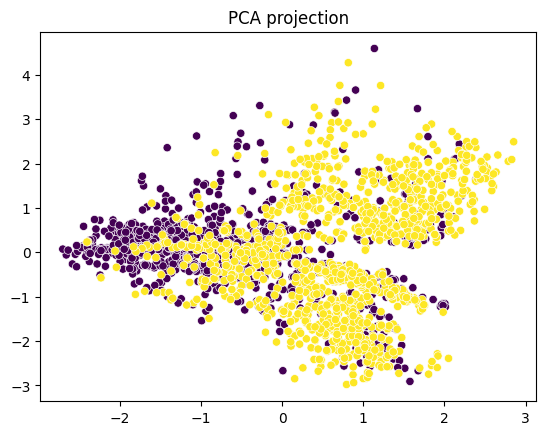

((2392, 2), (1351, 2))

In [12]:
from sklearn.decomposition import PCA

pca_reductor = PCA(n_components=2, random_state=RANDOM_SEED)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_pca = pca_reductor.fit_transform(X_train)

# Transforming test data with reductor fitted on train data
X_test_pca = pca_reductor.transform(X_test)

pca_plot = sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:,1], c=y_train.values.astype(int))
pca_plot.set_title("PCA projection")
plt.show()

X_train_pca.shape, X_test_pca.shape

#### 2.3.2 LDA reduction

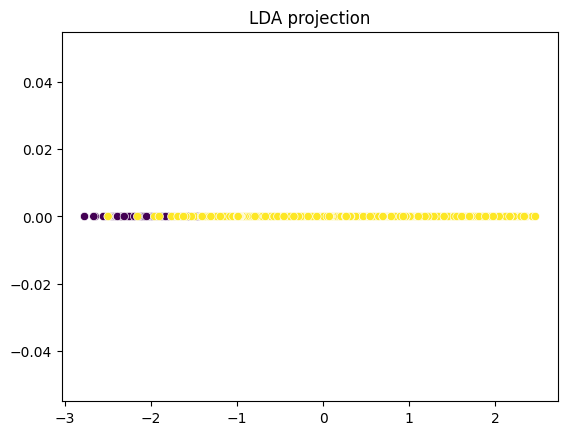

((2392, 1), (1351, 1))

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_reductor = LDA(n_components=1)	# n_components cannot be larger than min(n_features, n_classes - 1) = min(5, 1)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_lda = lda_reductor.fit_transform(X_train, y_train)

# Transforming test data with reductor fitted on train data
X_test_lda = lda_reductor.transform(X_test)

lda_plot = sns.scatterplot(x=X_train_lda[:, 0], y=np.zeros(shape=X_train_lda.shape[0]), c=y_train.values.astype(int))
lda_plot.set_title("LDA projection")
plt.show()

X_train_lda.shape, X_test_lda.shape

#### 2.3.3 t-SNE reduction

over sampling 

## 3. Classification

### 3.1 Shallow Machine Learning

#### 3.1.1 Decision Tree

normal dataset 

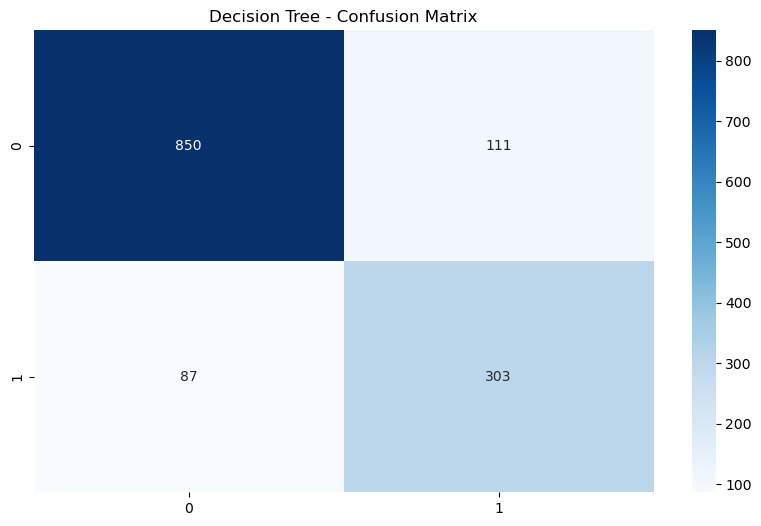

Accuracy: 0.8534418948926721
              precision    recall  f1-score   support

           1       0.91      0.88      0.90       961
           2       0.73      0.78      0.75       390

    accuracy                           0.85      1351
   macro avg       0.82      0.83      0.82      1351
weighted avg       0.86      0.85      0.85      1351



In [87]:

dt = DecisionTreeClassifier(max_depth=None, random_state=42, criterion='gini')
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8307091971504041


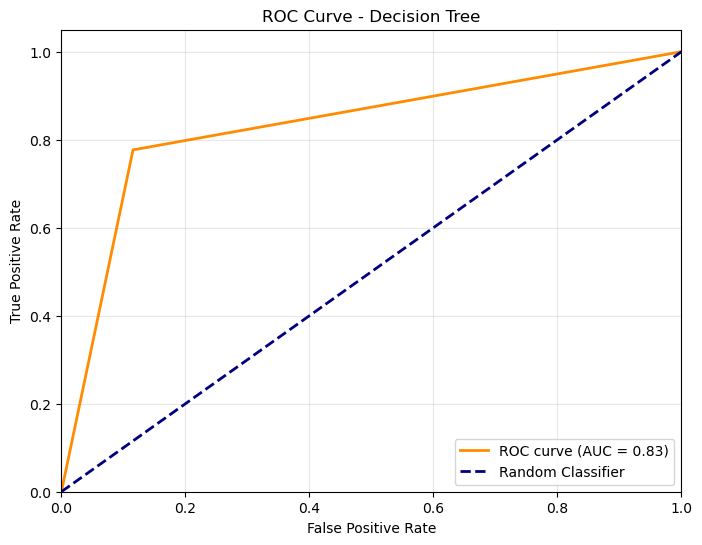

In [88]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = dt.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='2')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

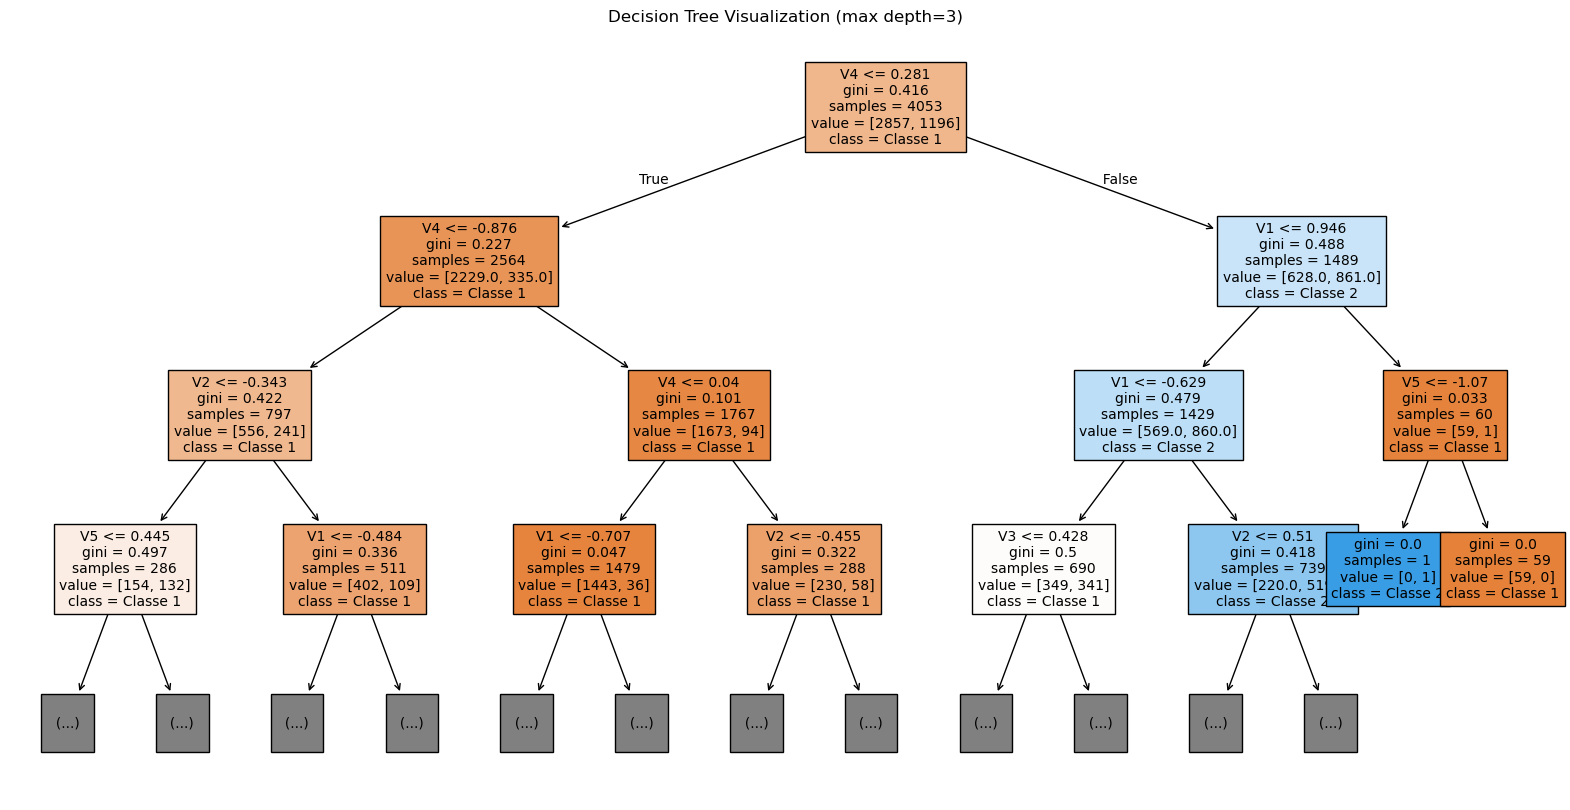

In [89]:
plt.figure(figsize=(20, 10))
plot_tree(dt, 
          feature_names=dataset.feature_names,
          class_names=['Classe 1', 'Classe 2'],  # Nomi personalizzati
          filled=True, 
          max_depth=3,
          fontsize=10)
plt.title("Decision Tree Visualization (max depth=3)")
plt.show()

#### 3.1.3 KNN Classifier

#### 3.1.4 SVM Classifier

### 3.2 Ensemble Classifiers Machine Learning 

#### 3.2.2 AdaBoost

#### 3.2.3 Extreme Gradient Boosting

#### 3.2.4 Custom Ensemble

### 3.3 Deep Learning

#### 3.3.1 Multi Layer Perceptron

## 4. Evaluation

## 5. Result Discussion